In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

import myfm

# read movielens 100k data.
from movielens100k_loader import load_dataset

df_train, df_test = load_dataset(
    id_only=True, fold=3
) # Note the dependence on the fold

In [2]:
df_train.head()

,user_id,movie_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,6,5,887431973


In [3]:
def test_myfm(df_train, df_test, rank=8, grouping=None, classification=False, n_iter=100, samples=95):
    explanation_columns = ['user_id', 'movie_id']
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_train = ohe.fit_transform(df_train[explanation_columns])
    X_test = ohe.transform(df_test[explanation_columns])
    y_train = df_train.rating.values
    y_test = df_test.rating.values
    if classification:
        y_train = y_train >= 4
        y_test = y_test >=4
        fm = myfm.MyFMClassifier(rank=rank, random_seed=334)
    else:
        fm = myfm.MyFMRegressor(rank=rank, random_seed=114514)
    
    if grouping:
        grouping = [ i for i, category in enumerate(ohe.categories_) for _ in category]

    fm.fit(X_train, y_train, grouping=grouping, n_iter=n_iter, n_kept_samples=samples)
    
    if classification:
        prediction = fm.predict_proba(X_test)
        roc = metrics.roc_auc_score(y_test, prediction)
        ll = metrics.log_loss(y_test, prediction)
        print('roc={roc}, ll={ll}'.format(roc=roc, ll=ll))
    else:
        prediction = fm.predict(X_test)
        rmse = ((y_test - prediction) ** 2).mean() ** .5
        mae = np.abs(y_test - prediction).mean()
        print('rmse={rmse}, mae={mae}'.format(rmse=rmse, mae=mae))
    return fm

### Regression

In [4]:
# basic regression
test_myfm(df_train, df_test, rank=8, classification=False);

alpha = 1.48 w0 = 3.25 : 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


rmse=0.9032126256432311, mae=0.7116432524241615


In [5]:
# with grouping
fm = test_myfm(df_train, df_test, rank=8, grouping=True, classification=False)

alpha = 1.56 w0 = 3.33 : 100%|██████████| 100/100 [00:02<00:00, 36.68it/s]


rmse=0.8959382764109612, mae=0.7048050699780434


### Classification

In [6]:
test_myfm(df_train, df_test, rank=8, classification=True);

alpha = 1.00 w0 = -0.08 : 100%|██████████| 100/100 [00:04<00:00, 22.33it/s]


roc=0.7684949499199077, ll=0.5698737002871701


In [7]:
test_myfm(df_train, df_test, rank=8, classification=True, grouping=True)

alpha = 1.00 w0 = 0.05 : 100%|██████████| 100/100 [00:05<00:00, 16.68it/s]


roc=0.780003453569525, ll=0.5585675065393141


### Plot the trace of hyper parameters

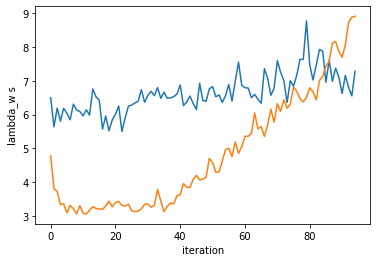

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot([ x.lambda_w for x in fm.hypers_]);
plt.xlabel('iteration');
plt.ylabel('lambda_w s');

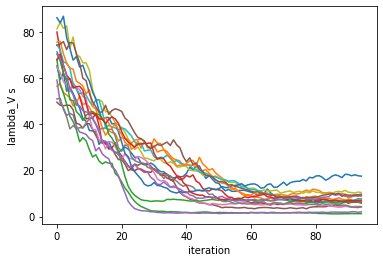

In [9]:
plt.xlabel('iteration');
plt.ylabel('lambda_V s');
plt.plot([ x.lambda_V.ravel() for x in fm.hypers_]);